In [1]:
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv, HumanoidEnvProthesis
from motion_imitation.utils.config import Config
import matplotlib.pyplot as plt
import glfw

In [2]:
cfg = Config('0202', False, create_dirs=False)
cfg_p = Config('0202_prothesis', False, create_dirs=False)
cfg.env_start_first = True
cfg_p.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.seed(cfg.seed)


body_qposaddr = get_body_qposaddr(env.model)
body_qposaddr_list_start_index = [idxs[0] for idxs in list(body_qposaddr.values())]
knee_idx = body_qposaddr_list_start_index[2]
def plot_qpos(qpos, body_qposaddr_list_start_index):
    fig, axs = plt.subplots(nrows=qpos.shape[1]//4+1, ncols=4, figsize=(10, 12))
    for i in range(qpos.shape[1]//4+1):
        for j in range(4):
            idx = i*4 + j
            if idx >= qpos.shape[1]:
                break
            gt = qpos[:, idx]
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].set_ylim([-np.pi, np.pi])
            if idx in body_qposaddr_list_start_index:
                body_name = [name for name, addr in body_qposaddr.items() if addr[0] == idx][0]
                axs[i, j].set_title(f"idx = {idx}, {body_name}", fontsize=12)
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_qpos(qpos, body_qposaddr_list_start_index )



env_p = HumanoidEnvProthesis(cfg_p, cfg)
env_p.seed(cfg_p.seed)

actuators = env.model.actuator_names
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actuators_f = env_p.model.actuator_names
state_dim_f = env_p.observation_space.shape[0]
action_dim_f = env_p.action_space.shape[0]

"""load learner policy"""
policy_net = PolicyGaussian(MLP(state_dim, cfg.policy_hsize, cfg.policy_htype), action_dim, log_std=cfg.log_std, fix_std=cfg.fix_std)
value_net = Value(MLP(state_dim, cfg.value_hsize, cfg.value_htype))
cp_path = '%s/iter_%04d.p' % (cfg.model_dir, 800)
logger.info('loading model from checkpoint: %s' % cp_path)
model_cp = pickle.load(open(cp_path, "rb"))
policy_net.load_state_dict(model_cp['policy_dict'])
value_net.load_state_dict(model_cp['value_dict'])
running_state = model_cp['running_state']


loading model from checkpoint: results/motion_im/0202/models/iter_0800.p


In [3]:
# change based on osl default controller
phase_list = ['e_stance', 'l_stance', 'e_swing', 'l_swing']
joint_list = ['knee', 'ankle', 'threshold']
# gain_list =  ['knee_stiffness', 'knee_damping', 'ankle_stiffness', 'ankle_damping', 'load', 'knee_angle', 'knee_vel', 'ankle_angle']
n_sets = env_p.OSL_CTRL.n_sets

for phase_name in phase_list: 
    env_p.OSL_CTRL.set_osl_param( phase_name, 'gain',  'ankle_stiffness', 0 , mode=0)
env_p.OSL_CTRL

In [4]:
class MyVisulizerFK(Visualizer):

    def __init__(self, vis_file):
        super().__init__(vis_file)
        ngeom = len(env.model.geom_rgba) - 1
        self.env_vis.model.geom_rgba[ngeom + 21: ngeom * 2 + 21] = np.array([0.7, 0.0, 0.0, 1])
        self.env_vis.viewer.cam.lookat[2] = 1.0
        self.env_vis.viewer.cam.azimuth = 45
        self.env_vis.viewer.cam.elevation = -8.0
        self.env_vis.viewer.cam.distance = 5.0
        self.T = 12

    def data_generator(self):
        poses = {'pred': [], 'gt': []}
        osl_infos = { 'phase': [], 'osl_sense_data': {'knee_angle': [], 'knee_vel': [], 'ankle_angle': [], 'ankle_vel': [], 'load': []}}
        vfs = []
        state = env_p.reset()
        assert env_p.init_qpos_p[1] == env.expert['qpos'][0,1], "init_qpos[1] != expert_qpos[0,1]"
        assert np.allclose(env_p.init_qpos_p, env_p.data.qpos), "init_qpos[1] != qpos[0,1]"
        if running_state is not None:
            state = running_state(state, update=False)
        for t in range(10000): 
            print(t)
            epos = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
            if env.expert['meta']['cyclic']:
                init_pos = env.expert['init_pos']
                cycle_h = env.expert['cycle_relheading']
                cycle_pos = env.expert['cycle_pos']
                epos[:3] = quat_mul_vec(cycle_h, epos[:3] - init_pos) + cycle_pos 
                epos[3:7] = quaternion_multiply(cycle_h, epos[3:7])
            poses['gt'].append(epos) 
            qpos = env_p.data.qpos.copy()
            qpos = np.concatenate([qpos[:knee_idx+1], np.zeros(2), qpos[knee_idx+1:]])
            poses['pred'].append(qpos)
            
            state_var = tensor(state, dtype=dtype).unsqueeze(0)
            action = policy_net.select_action(state_var, mean_action=True)[0].cpu().numpy()
            next_state, reward, done, fail = env_p.step(action)
            osl_info = env_p.osl_info

            osl_infos['phase'].append(osl_info['phase'])
            vfs.append(env_p.vf)
            for key in osl_infos['osl_sense_data']:
                osl_infos['osl_sense_data'][key].append(osl_info['osl_sense_data'][key])

            if running_state is not None:
                next_state = running_state(next_state, update=False)
            if done:
                break
            state = next_state
            # print("np.std(state) vs ",np.std(state), np.std(epos))

        poses['gt'] = np.vstack(poses['gt'])
        poses['pred'] = np.vstack(poses['pred'])
        plot_pose = False
        if plot_pose:
            # import matplotlib.pyplot as plt
            fig, axs = plt.subplots(nrows=poses['gt'].shape[1]//4+1, ncols=4, figsize=(10, 12))
            for i in range(poses['gt'].shape[1]//4+1):
                for j in range(4):
                    if i*4 + j < poses['gt'].shape[1]:
                        gt = poses['gt'][:, i*4 + j]
                        pred = poses['pred'][:, i*4 + j]
                        mse = np.mean((gt - pred) ** 2)
                        axs[i, j].plot(gt, 'r', label='gt')
                        axs[i, j].plot(pred, 'b', label='pred')
                        axs[i, j].set_ylim([-np.pi, np.pi])
                        axs[i, j].set_title(f'{i*4 + j} MSE: {mse:.4f}')
                    if i == 0 and j == 0:
                        axs[i, j].legend()
            plt.tight_layout()
            plt.show()
        plot_sensor = True
        # import matplotlib.pyplot as plt
        if plot_sensor:
            fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(7, 14))
            phases = ['e_stance', 'l_stance', 'e_swing', 'l_swing']
            phase_colors = {'e_stance': 'r', 'l_stance': 'g', 'e_swing': 'b', 'l_swing': 'y'}
            phase_data = osl_infos['phase']
            
            phase_values = {'e_stance': 1, 'l_stance': 2, 'e_swing': 3, 'l_swing': 4}
            phase_line = [phase_values[phase] for phase in phase_data]
            axs[0].plot(phase_line, label='phase change', color='black',  marker='o')
            axs[0].legend()
            
            sensor_names = ['knee_angle', 'knee_vel', 'ankle_angle', 'ankle_vel', 'load']
            for i, name in enumerate(sensor_names):
                if 'ankle' in name or 'knee' in name:
                    axs[i+1].plot(np.rad2deg(osl_infos['osl_sense_data'][name]), marker='o', label=name)
                else:
                    axs[i+1].plot(osl_infos['osl_sense_data'][name], marker='o', label=name)
                axs[i+1].set_title(name)
                axs[i+1].set_ylabel('deg' if 'angle' in name else 'deg/s' if 'vel' in name else 'N')
                axs[i+1].legend()
                
            
            plt.tight_layout()
            plt.show()
        self.num_fr = poses['pred'].shape[0]
        plot_extf = True
        if plot_extf:
            vfs = np.vstack(vfs)
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
            vf_xyz = vfs[:, :3]
            vf_mag = np.linalg.norm(vf_xyz, axis=1)
            for j in range(3):
                axs[0].plot(vf_xyz[:,j], marker='o', label=f'ext_f_{j}')
                
            axs[1].plot(vf_mag, marker='o', label=f'extf magnitude')
            axs[0].legend()
            axs[1].legend()
            plt.tight_layout()
            plt.show()
        yield poses

            

    def update_pose(self):
        self.env_vis.data.qpos[:env.model.nq] = self.data['pred'][self.fr]
        self.env_vis.data.qpos[env.model.nq:] = self.data['gt'][self.fr] 
        self.env_vis.data.qpos[env.model.nq] += 1.0 # time update
        # if args.record_expert:
        # self.env_vis.data.qpos[:env.model.nq] = self.data['gt'][self.fr]
        if True: #args.hide_expert:
            self.env_vis.data.qpos[env.model.nq + 2] = 100.0
        # if args.focus:
        #     self.env_vis.viewer.cam.lookat[:2] = self.env_vis.data.qpos[:2]
        self.env_vis.sim_forward()

    def record_video(self, preview = False):
        frame_dir = f'out/videos/prothesis/frames'
        if os.path.exists(frame_dir):
            shutil.rmtree(frame_dir)
        os.makedirs(frame_dir, exist_ok=True)
        for fr in range(self.num_fr):
            # print("hi")
            self.fr = fr
            self.update_pose()
            for _ in range(200): 
                self.render()
            if not preview:
                t0 = time.time()
                # save_screen_shots(self.env_vis.viewer.window,f'{frame_dir}/%04d.png' % fr,  autogui = True)
                
                width, height = glfw.get_window_size(self.env_vis.viewer.window)
                data = self.env_vis._get_viewer("human").read_pixels(width, height, depth=False)
                save_image_hwc(data[::-1, :, [0,1,2]],  f'{frame_dir}/%04d.png' % fr)
                print('%d/%d, %.3f' % (fr, self.num_fr, time.time() - t0))
         
        if preview:
            out_name = f'out/videos/prothesis/0202_800.mp4'
            cmd = ['ffmpeg', '-y', '-r', '30', '-f', 'image2', '-start_number', '0',
                '-i', f'{frame_dir}/%04d.png', '-vcodec', 'libx264', '-crf', '5', '-pix_fmt', 'yuv420p', out_name]
            subprocess.call(cmd)

0
action_ow [0. 0.] osl_ctrl {'knee': -6.037114810943857, 'ankle': 0.0}
1
action_ow [0. 0.] osl_ctrl {'knee': -35.120525276684475, 'ankle': 0.0}
2
key knee_angle, thres 0.5235987755982988, cond below Transitioning to  e_stance
action_ow [0. 0.] osl_ctrl {'knee': -62.21016429033877, 'ankle': 0.0}
3
key load, thres 74.49570108810686, cond above Transitioning to  l_stance
action_ow [0. 0.] osl_ctrl {'knee': -22.285859353098253, 'ankle': 0.043232442847078}
4
action_ow [0. 0.] osl_ctrl {'knee': -41.10981694660064, 'ankle': 0.05713011827826574}
5
action_ow [0. 0.] osl_ctrl {'knee': -53.27818144876845, 'ankle': 0.027146802790839412}
6
action_ow [0. 0.] osl_ctrl {'knee': -51.04019145459936, 'ankle': -0.03389354614752483}
7
action_ow [0. 0.] osl_ctrl {'knee': -47.873305636492034, 'ankle': -0.04562775906645771}
8
action_ow [0. 0.] osl_ctrl {'knee': -44.04743093526356, 'ankle': 0.0006325921297467525}
9
action_ow [0. 0.] osl_ctrl {'knee': -40.22921898750697, 'ankle': 0.046136674703860237}
10
actio

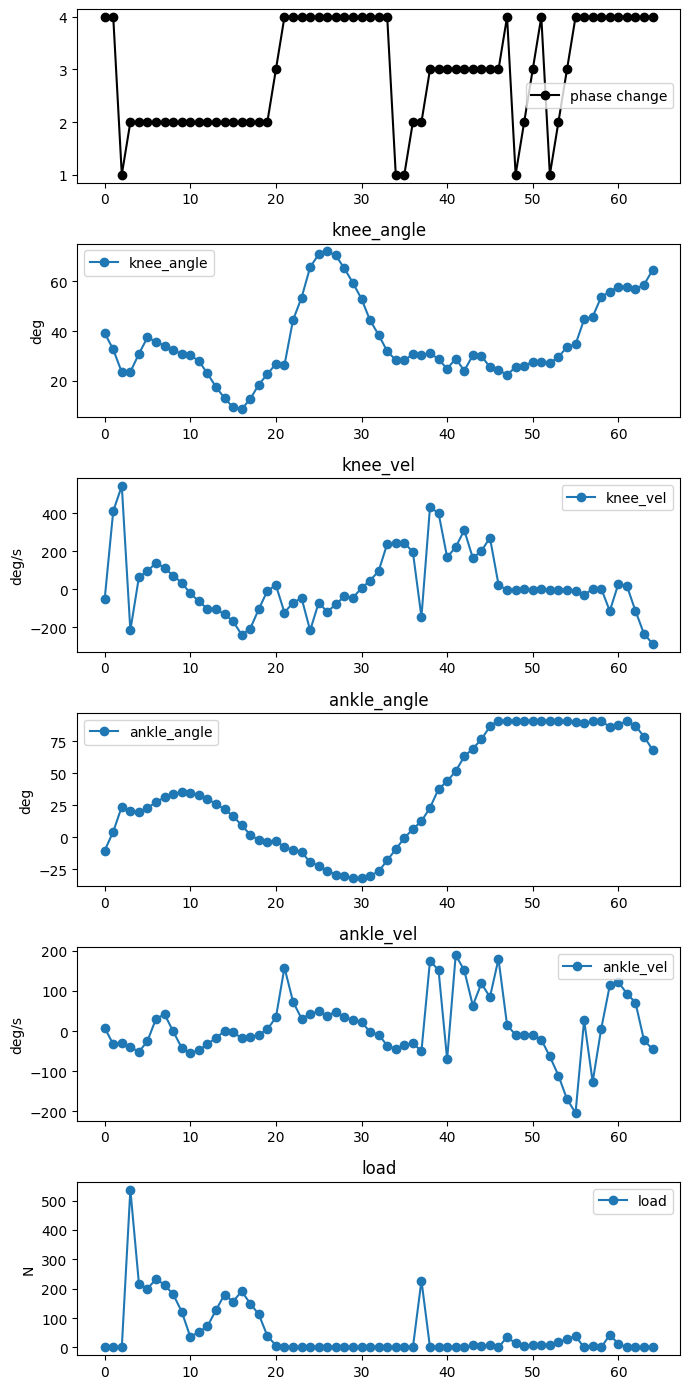

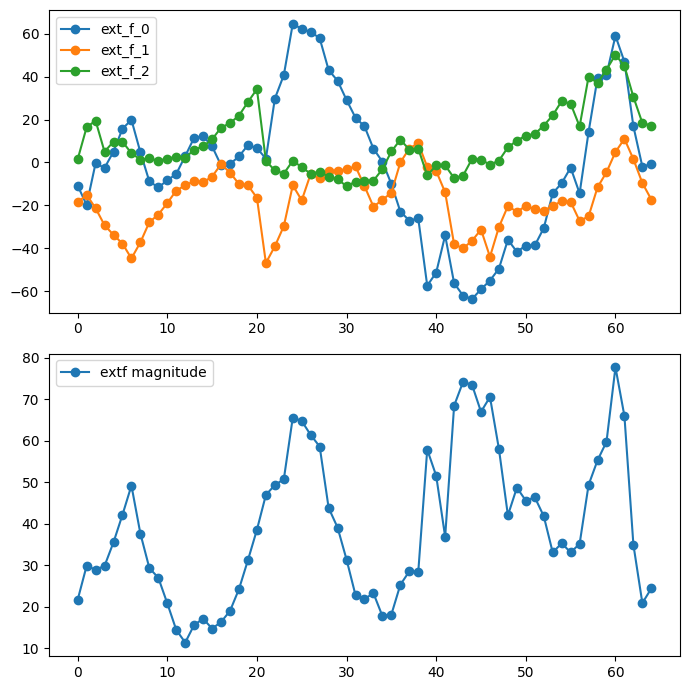

Creating window glfw


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwe

In [ ]:

vis = MyVisulizerFK(f'mocap_v2_vis.xml')
# vis.num_fr

vis.record_video(preview = False)


In [6]:
np.sum(env_p.model.body_mass)



30.37541328770922

In [7]:
vis.data['pred'][vis.fr].shape

(39,)

In [8]:
env_p.OSL_CTRL.OSL_PARAM_LIST

{0: {'e_stance': {'gain': {'knee_stiffness': 99.372,
    'knee_damping': 3.18,
    'knee_target_angle': 0.08726646259971647,
    'ankle_stiffness': 0,
    'ankle_damping': 0,
    'ankle_target_angle': -0.03490658503988659},
   'threshold': {'load': (74.49570108810686, 'above'),
    'ankle_angle': (0.10471975511965978, 'above')}},
  'l_stance': {'gain': {'knee_stiffness': 99.372,
    'knee_damping': 1.272,
    'knee_target_angle': 0.13962634015954636,
    'ankle_stiffness': 0,
    'ankle_damping': 0.063,
    'ankle_target_angle': -0.3490658503988659},
   'threshold': {'load': (29.798280435242745, 'below')}},
  'e_swing': {'gain': {'knee_stiffness': 39.749,
    'knee_damping': 0.063,
    'knee_target_angle': 1.0471975511965976,
    'ankle_stiffness': 0,
    'ankle_damping': 0,
    'ankle_target_angle': 0.4363323129985824},
   'threshold': {'knee_angle': (0.8726646259971648, 'above'),
    'knee_vel': (0.05235987755982989, 'below')}},
  'l_swing': {'gain': {'knee_stiffness': 15.899,
    'k

In [9]:
thresholds = [env_p.OSL_CTRL.osl_state_list[p].get_thresholds() for p in env_p.OSL_CTRL.osl_state_list.keys()]
phases = list(env_p.OSL_CTRL.osl_state_list.keys())

for phase, threshold in zip(phases, thresholds):
    print(f"Phase: {phase}")
    for key, value in threshold.items():
        if 'angle' in key or 'vel' in key:
            angle_in_degrees = np.degrees(value[0])
            print(f"{key}: ({angle_in_degrees:.2f} degrees, {value[1]})")
        else:
            print(f"{key}: {value}")

Phase: e_stance
load: (74.49570108810686, 'above')
ankle_angle: (6.00 degrees, above)
Phase: l_stance
load: (29.798280435242745, 'below')
Phase: e_swing
knee_angle: (50.00 degrees, above)
knee_vel: (3.00 degrees, below)
Phase: l_swing
load: (119.19312174097098, 'above')
knee_angle: (30.00 degrees, below)
